# GPU-accelerated Filtered Backprojection

Using Astra.

In [1]:
# Import relevant packages

from __future__ import division
from os import mkdir
from os.path import join, isdir
from imageio import get_writer
 
import astra
import numpy as np
from tifffile import imsave
from skimage import io
import matplotlib.pyplot as plt

# Timing
from tqdm import tqdm
import time

# Garbage collection
import gc

import sys
sys.path.append('../')
from Srayan_autoalign import srayan_autoalign

Code starts here

Reconstruction of our image from 2D geometry

In [67]:
del im
del reconstruction_fbp
gc.collect()

# PATH_TO_IMAGE =  'embryo_stack.tif'
PATH_TO_IMAGE = r'D:\MSci_Project\1_Data\2023-02-10 10pc 15um 3d phantom\2023-02-10 10pc 15um 3d phantom fa 400proj\1_1\1_1_MMStack_Pos0.ome.tif'
PATH_TO_IMAGE = r'D:\MSci_Project\1_Data\2023-02-13\2023-02-13 10pc 15um 3d phantom focal scan\2023-02-13 fd -2mm\MMStack_Pos0.ome.tif'
im = io.imread(PATH_TO_IMAGE)
print(im.shape)
print(type(im))
#srayan_autoalign.plot_alignment(im)

# Crop image to centre the centre of the image on the rotation axis
im = im[:,:,2:]
im.shape

(400, 1392, 1040)
<class 'numpy.ndarray'>


(400, 1392, 1038)

In [68]:
# im = srayan_autoalign.apply_offset(im)

In [69]:
# Turn into sinogram
im = np.moveaxis(im, 0, -2).astype('float64')
print(im.shape)

# Preallocate Memory
reconstruction_fbp = np.zeros((im.shape[0], im.shape[2], im.shape[2]))

(1392, 400, 1038)


This code reconstructs the image. 

First time running set `maximum_value = 65535`.

In [70]:
# Configuration.
num_of_projections = 400
output_dir = 'fd_-2mm'
maximum_value =  65535
save_reconstruction = True

# Infer parameters from inputs
detector_rows = im.shape[0]  # Vertical size of detector [pixels].
detector_cols = im.shape[-1]  # Horizontal size of detector [pixels].
angles = np.linspace(0, 2 * np.pi, num=num_of_projections, endpoint=False)

start = time.time()
for i in tqdm(range(im.shape[0])):
    # Copy projection images into ASTRA Toolbox.
    proj_geom = \
      astra.create_proj_geom('parallel', 1.0, detector_cols, angles)
    projections_id = astra.data2d.create('-sino', proj_geom, im[i])

    # Create reconstruction.
    vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols,
                                              detector_rows)
    reconstruction_id = astra.data2d.create('-vol', vol_geom, data=0)
    alg_cfg = astra.astra_dict('FBP_CUDA')
    alg_cfg['ProjectionDataId'] = projections_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id
    algorithm_id = astra.algorithm.create(alg_cfg)
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data2d.get(reconstruction_id)

    # Limit and scale reconstruction.
    reconstruction[reconstruction < 0] = 0
    reconstruction /= maximum_value
    reconstruction = np.round(reconstruction * 65535).astype(np.uint16)

    # Save reconstruction.
    if save_reconstruction: 
        if not isdir(output_dir):
            mkdir(output_dir)
        #for i in range(detector_rows):
            #im = reconstruction[i, :, :]
            #im = np.flipud(im)
        imsave(join(output_dir, 'reco%04d.tif' % i), reconstruction)
    
    # Save reconstruction to preallocated memory
    reconstruction_fbp[i] = reconstruction
    
    # Cleanup.
    astra.algorithm.delete(algorithm_id)
    astra.data2d.delete(reconstruction_id)
    astra.data2d.delete(projections_id)

end = time.time()
print(end-start)

#plt.imshow(reconstruction)

100%|██████████████████████████████████████████████████████████████████████| 1392/1392 [01:11<00:00, 19.36it/s]

71.91116237640381


In [63]:
np.max(reconstruction_fbp)

6376.0

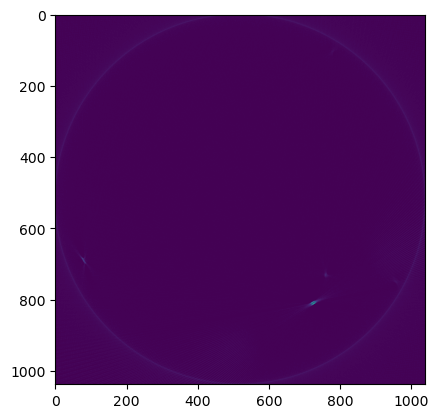

In [52]:
plt.imshow(reconstruction_fbp[6]) #696

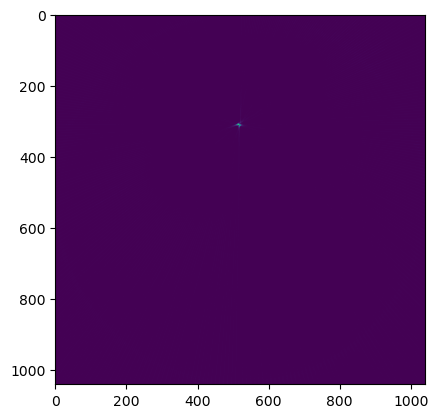

In [13]:
plt.imshow(reconstruction_fbp[696]) #696

3. Comparison with the performance of the 'iradon' function in skimage

20.00656485557556


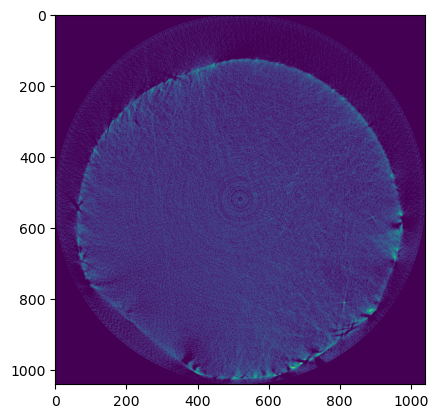

In [12]:
from skimage.transform import iradon
start = time.time()
skimage_output = iradon(np.moveaxis(im[400],0,1), theta=angles*180/np.pi, filter_name='ramp')
end = time.time()
print(end-start)
skimage_output[skimage_output < 0] = 0
plt.imshow(skimage_output)

In [14]:
3.86/0.0156

247.43589743589743